In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

# Inference with ELFI: the MA(2) model

The 2nd order moving average model, MA(2), is a common model used in univariate time analysis. Assuming zero mean it can be written as

$$
y_t = w_t + \theta_1 w_{t-1} + \theta_2 w_{t-2},
$$

where $\theta_1, \theta_2 \in \mathbb{R}$ and $(w_k)_{k\in \mathbb{Z}} \sim N(0,1)$ represents an independent and identically distributed sequence of white noise.

### The observed data and the inference problem

In this notebook, our task is to infer the parameters $\theta_1, \theta_2$ given a sequence of 100 observations $y$ that originate from an MA(2) process. Let's define this MA(2) simulator as a Python function:

In [2]:
def MA2(t1, t2, n_sim=1, prng=None):
    n_obs = 100
    if prng is None:
        prng = np.random.RandomState()
    w = prng.randn(n_sim, n_obs+2) # i.i.d. sequence ~ N(0,1)
    y = w[:,2:] + t1 * w[:,1:-1] + t2 * w[:,:-2]
    return y

In ELFI, all data is in at least 2-dimensional NumPy arrays with different observations on the 0-axis. **Important**: in order to guarantee a consistent state of pseudo-random number generation, the simulator must have `prng` as a keyword argument for reading in a `numpy.RandomState` object. Additionally, a simulator that supports vectorized operations should accept the keyword argument `n_sim` that defines how many sequences should be returned.

Let's now use this simulator to create the observations with true parameter values $\theta_1=0.6, \theta_2=0.2$ (from now on these are considered unknown):

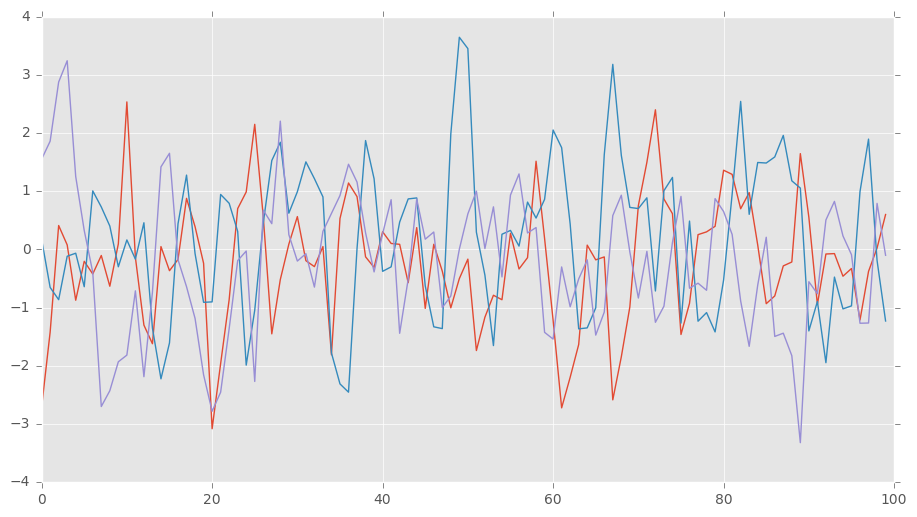

In [3]:
# true parameters
t1_0 = 0.6
t2_0 = 0.2

# Set up observed data y
y = MA2(t1_0, t2_0)

# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y.flatten());

# To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:
plt.plot(MA2(t1_0, t2_0).flatten());
plt.plot(MA2(t1_0, t2_0).flatten());

### Approximate Bayesian Computation

The figure above illustrates the difficulty of inferring $\theta_1, \theta_2$. One way to approach this kind of problems is Approximate Bayesian Computation (ABC), which is based on the intuition that similar data is likely to have been produced by similar parameters. Although the idea may appear inapplicable for the task at hand, it works when a large number of samples can be used. For more information about ABC, please see e.g. 

* Marin, J.-M., Pudlo, P., Robert, C. P., and Ryder, R. J. (2012). Approximate Bayesian computational
methods. *Statistics and Computing*, 22(6):1167–1180.
* Lintusaari, J., Gutmann, M. U., Dutta, R., Kaski, S., and Corander, J. (2016). Fundamentals and recent
developments in approximate Bayesian computation. *Systematic Biology*, in press.
* https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

### Defining the inference problem in ELFI

In ELFI, the inference problem is described in the form of a directed acyclic graph ([DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)), which associates each node with its parent nodes. This provides an intuitive means to describe complex dependencies that are automatically fulfilled by the inference engine. So let's build such a model.

As is usual in Bayesian statistical inference, we need to define *prior* distributions for the unknown parameters $\theta_1, \theta_2$. In ELFI the priors can be any of the continuous and discrete distributions available in `scipy.stats` (for custom priors, see below). For simplicity, let's start by assuming that both parameters follow `Uniform(0, 2)`.

In [4]:
import elfi

# a node is defined by giving it a name, a distribution from scipy.stats and its parents (here constants)
t1 = elfi.Prior('t1', scipy.stats.uniform, 0, 2)

# ELFI also supports giving the scipy.stats distributions as strings
t2 = elfi.Prior('t2', 'uniform', 0, 2)

Next, we define the *Simulator* node by giving it the `MA2` function, and the priors as its parents. As this node can be compared with observations, we give them as well.

In [5]:
Y = elfi.Simulator('MA2', MA2, t1, t2, observed=y)

But how does one compare the simulations with the observed sequence? As was evident from the plot of just a few observed sequences, a direct pointwise comparison is unproductive. Indeed, the comparison of simulated sequences is often the most difficult (and arbitrary) part of ABC. Typically one chooses one or more *ad hoc* summary statistics and then calculates the discrepancy between those.

Here, we will apply the intuition arising from the definition of the MA(2) process, and use the autocovariances with lags 1 and 2 as the summary statistics, and evaluate the discrepancy with the common Euclidean L2-distance.

In [6]:
def autocov(x, lag=1):
    mu = np.mean(x, axis=1, keepdims=True)
    var = np.var(x, axis=1, keepdims=True, ddof=1)
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1, keepdims=True) - mu**2
    tau = C / var
    return tau

def distance(x, y):
    d = np.linalg.norm( np.array(x) - np.array(y), ord=2, axis=0)
    return d

As is familiar by now, a `Summary` node is defined by giving the autocovariance function and the simulated data (which includes the observed as well):

In [7]:
S1 = elfi.Summary('S1', autocov, Y)

The node syntax requires a function, so defining the second summary statistic as autocovariance with lag 2 is a bit more involved. Instead a writing a complete function from scratch, we can create a *closure* that fixes the keyword argument `lag`:

In [8]:
from functools import partial

# this is a more efficient way to say `lambda x: autocov(x, lag=2)`
autocov2 = partial(autocov, lag=2)

S2 = elfi.Summary('S2', autocov2, Y)
d = elfi.Discrepancy('d', distance, S1, S2)

Now that the inference model is defined, ELFI can visualize the DAG:

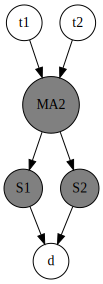

In [9]:
elfi.draw_model(d)

### Defining custom priors

Although the above definition is perfectly valid, having both prior distributions as `Uniform(0,2)` is bad, as the case becomes unidentifiable (i.e. the solution is not unique). To avoid this, *Marin et al. (2012)* defined the priors such that $-2<\theta_1<2$ with $\theta_1+\theta_2>-1$ and $\theta_1-\theta_2<1$ i.e. the parameters are sampled from a triangle (see below).

In ELFI, custom distributions can be defined by defining **static** classes that inherit a distribution from scipy.stats. In this case we only need these for sampling, so implementing the static `rvs` method suffices. As was in the context of simulators, it is important to accept the keyword argument `random_state`, which is needed for ELFI's internal book-keeping of pseudo-random number generation.

In [12]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class MarinPrior_t1(scipy.stats.rv_continuous):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class MarinPrior_t2(scipy.stats.rv_continuous):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2

These indeed sample from a triangle:

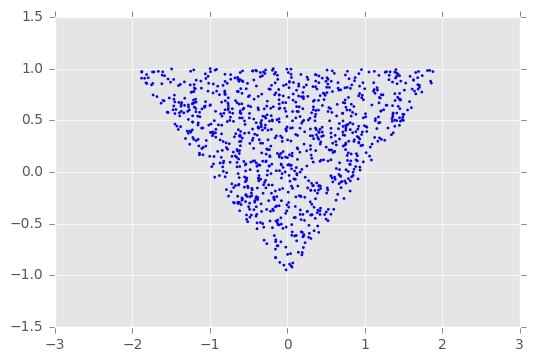

In [14]:
t1s0 = MarinPrior_t1.rvs(2, 1000)
t2s0 = MarinPrior_t2.rvs(t1s0, 1, 1000)
plt.scatter(t1s0, t2s0, s=4, edgecolor='none');

Let's change the earlier priors to the new ones in the inference model:

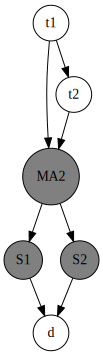

In [16]:
# define new priors
t1m = elfi.Prior('t1', MarinPrior_t1, 2)
t2m = elfi.Prior('t2', MarinPrior_t2, t1, 1)

# change these in place of the earlier nodes, keeping the old children
t1 = t1.change_to(t1m, transfer_parents=False, transfer_children=True)
t2 = t2.change_to(t2m, transfer_parents=False, transfer_children=True)

elfi.draw_model(d)

### Basic inference with rejection sampling

The simplest ABC algorithm samples parameters from their prior distributions, runs the simulator with these and compares to the observations. The samples are accepted or rejected depending on large the discrepancy is. 

In ELFI, ABC methods are initialized with the discrepancy node and a list of inferred parameters (in Python lists are defined with square brackets). 

In [22]:
rej = elfi.Rejection(d, [t1, t2])

After the ABC method has been initialized, samples can be drawn from it. By default, rejection sampling in ELFI works in `quantile` mode i.e. a certain quantile of the samples with smallest discrepancies is returned in a dictionary. The `sample` method requires the number of output samples as a parameter. Note that the simulator is then run `(N/quantile)` times.

In [30]:
# Time and run the simulator in parallel
N = 10000
%time result = rej.sample(N, quantile=0.01)

[t1_post, t2_post] = result['samples']
print("Number of accepted samples {} with threshold {:.2f}".format(len(t1_post), result['threshold']))
print("Posterior means: {:.2f} {:.2f}".format(t1_post.mean(), t2_post.mean()))

CPU times: user 11.1 s, sys: 2.37 s, total: 13.4 s
Wall time: 5.02 s
Number of accepted samples 10000 with threshold 0.05
Posterior means: 0.71 0.05


Rejection sampling can also be performed `threshold` based i.e. returning all samples that result in a discrepancy below certain threshold.

In [29]:
%time result2 = rej.sample(N, threshold=0.1)

CPU times: user 83.8 ms, sys: 36 ms, total: 120 ms
Wall time: 106 ms


### Visualizing inference

this needs a lot more work...

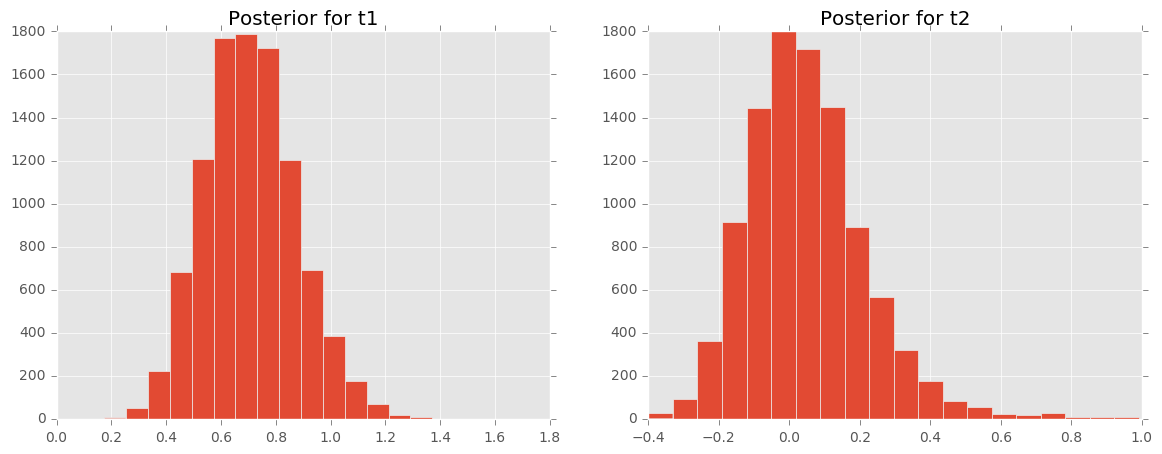

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(14,5));
ax[0].hist(t1_post, bins=20);
ax[0].set_title("Posterior for t1");
ax[1].hist(t2_post, bins=20);
ax[1].set_title("Posterior for t2");

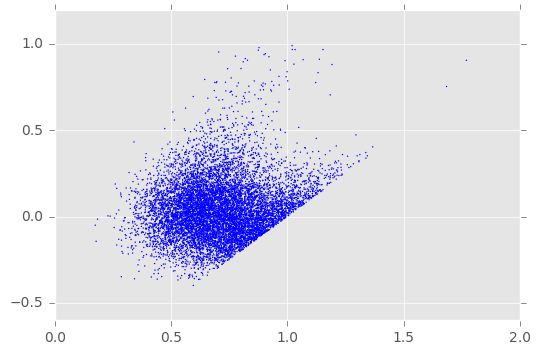

In [26]:
plt.scatter(t1_post, t2_post, s=1, edgecolor='none');

### Automatic parallelization

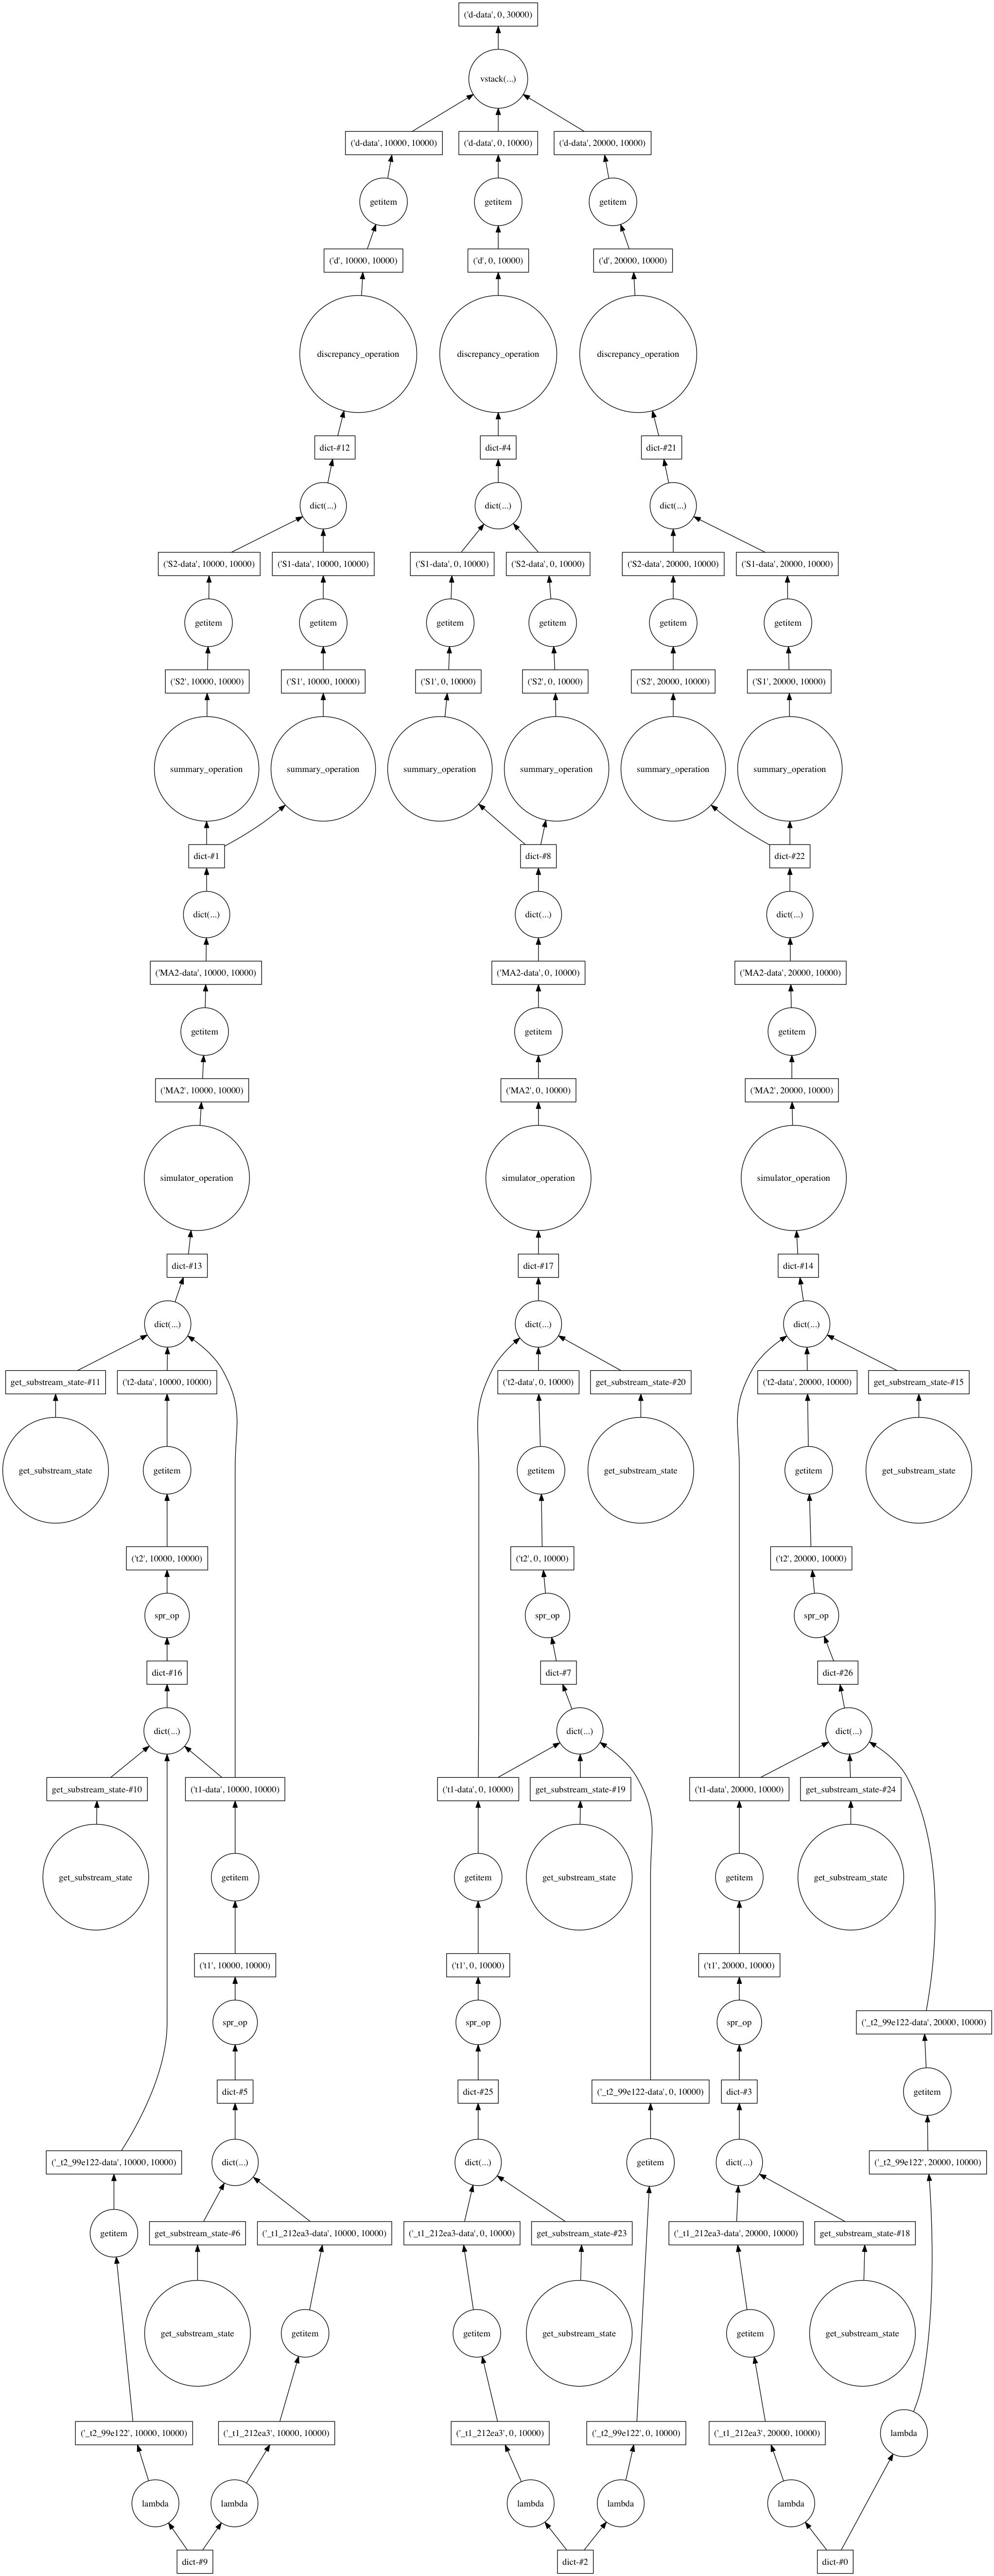

In [28]:
# Visualize the underlying dask graph
from dask.dot import dot_graph
dot_graph(d[0:30000].dask)

### Saving output

### Sequential Monte Carlo sampling

### Bayesian Optimization for Likelihood-Free Inference (BOLFI)